# Lecture 8: MCMC, convergence test and other considerations

AM207: Pavlos Protopapas, Harvard University

Feb 20 2014


------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from scipy.stats import distributions

C:\Users\vkaynig\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Convergence Test

We saw last lecture (or this one) that theory quarantees that a sequence drawn using MH is actually derived from the true posterior distribution of interest (aka target distribution). This is of course true as the number of samples approaches infinity. This is not very practical! We would like to know the minimum number of samples required to ensure a reasonable approximation to the target distribution. Unfortunately, there is no universal threshold that works across all problems, so convergence must be assessed independently each time MCMC estimation is performed. There are number of such tests and collectively collectively are known as convergence diagnostics. 

We can classify these methods as analytical or formal and ad-hoc methods.


__Formal methods:__ One could check the variance at different parts of the chain and compare that to the limiting distribution. And to compare, they use some form of  distance metrics to analyze convergence. It is also common to place theoretical bounds on the sample variance. In general these methods are generally difficult to use and are not prominent in the MCMC literature.



__Heuristic approach:__ Alternatively rather than considering the properties of the theoretical target distribution, we analyze the statistical properties of the chain. However depending on the sample alone convergence cannot be guaranteed. However the lack of convergence does correctly imply lack of convergence, however the absence of such evidence will not guarantee convergence in the chain. Strangely, negative results for one or more criteria is commonly used as an assurance that the sample will provide valid inferences.

For many  models, convergence  occurs quickly. It is not uncommon that convergence happens within a few hundred iterations (__burn-in__), after which all remaining samples of the chain may be used to calculate posterior quantities. For  complex models, convergence requires a significantly longer __burn-in__ time. Frequently, lack of convergence will be caused by poor __mixing__. Mixing refers to the degree to which the Markov chain explores the support of the posterior distribution. Poor mixing may be due to inappropriate proposals (too small step) or from attempting to estimate models with highly correlated variables.

The easiest approach for testing convergence is based on simply plotting and inspecting traces and histograms of the observed MCMC sample. If the trace of values for each of the stochastics exhibits asymptotic behavior over the last $m$ iterations, this may be satisfactory evidence for convergence.

### Example. Bioassay experiment

We demonstrate this with an example and examine the convergence of the resulting samples. 

Bioassay (commonly used shorthand for biological assay), or biological standardisation is a type of scientific experiment. Bioassays are typically conducted to measure the effects of a substance on a living organism and are essential in the development of new drugs and in monitoring environmental pollutants. Both are procedures by which the potency (pharmacology) or the nature of a substance is estimated by studying its effects on living matter.

In this experiment 5 animals were tested for various doses and the number of deaths were recorded. The  death rate is usually modeled as logit$^{-1}$ with two parameters (see below). The goal is to estimate those parameters and be able to infer death rates as a function of dose. 

In [2]:
n=5
X=np.array([-0.86,-0.30,-0.05,0.73])
Y=np.array([0,1,3,5])

The likelihood since is a success/fail experiment is expressed as a Binomial:

$$ P(D_i|\theta_i) = p(y_i, n_i| \theta_i) = {\rm Bionomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta$ is the rate of deaths which is modeled as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

We use flat priors for $\alpha,\beta$: 

$$ p(\alpha, \beta) \propto 1 $$

Posterior: 

$$ p(\alpha, \beta \vert y) \propto p(\alpha, \beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) $$
$$ = 1 \prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} $$



In [3]:
## invLogit
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x))

## posterior
def calc_posterior(a, b, y=Y, x=X):
    # Calculate joint posterior, given values for a, b 

    # Priors on a,b
    p = 1
    p = np.product((logitInv(a+b*x)**y)*(1.0-logitInv( a+b*x))**(n-y))
    
    return p

In [4]:
# check my posterior. I do a brute force just to make sure I do the right thing
X1 = np.linspace(-3,7,101)
X2 = np.linspace(-10, 30,100)
k=0;j=0
pp=np.zeros((101,100))
for x1 in X1:
    j=0
    for x2 in X2:
        pp[k,j]=calc_posterior(x1,x2)
        j +=1
    k +=1
    


Lets define a MH method we can use later too

In [5]:
rnorm = np.random.normal
runif = np.random.rand



def metropolis(n_iterations, initial_values, prop_var=1):
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000: print 'Iteration', i
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        for j in range(n_params):
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_prob/current_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if (u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1

            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            p[j] = trace[i+1,j]
    return trace, accepted

## also define a better autocorr function 
def autocorr(x):
   result = np.correlate(x, x, mode='full')
   result = result/result[result.size/2]
   return result[result.size/2:]

Create the sample for the posterior using MH

In [6]:
n_iter = 50000
trace, acc = metropolis(n_iter, (11,17), 1)

Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000


In [7]:
burnin = 5000    # MY BURN IN 
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

print acc

[32183, 45699]


(0, 1000)

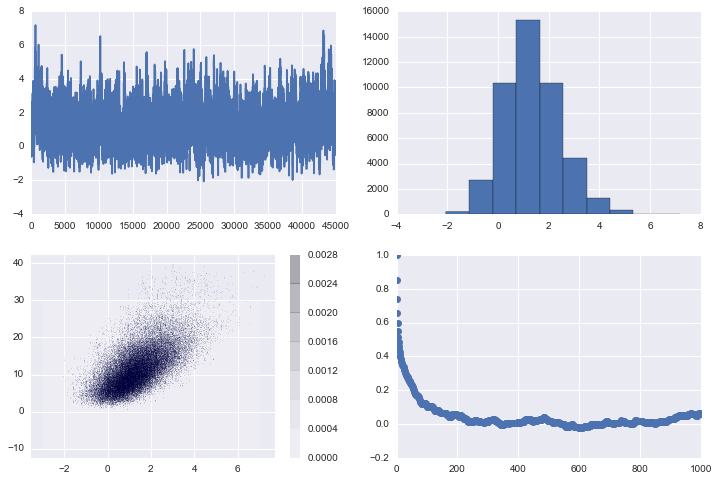

In [8]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1) 
plt.plot(alpha)
plt.subplot(2,2,2) 
fig=plt.hist(alpha)
plt.subplot(2,2,3)

plt.contourf(X1,X2,pp.T, alpha=0.3)
plt.colorbar()
plt.scatter(alpha, beta, s=0.2, alpha=0.2)
plt.subplot(2,2,4)
plt.acorr(alpha-np.mean(alpha),  normed=True, usevlines=False, maxlags=1000, label=u'Shuffled')

plt.xlim( (0,1000))

How to fix bad mixing? Change the proposal step. 

## Thinning
Thining is a way of reducing autocorrelation from the sample. MH is a markov chain and therefore by construction is not iid and therefore will exhibit high autocorrelation. 
Thining is a process of removing samples from the chain in order to produce a chain with lower autocorrelation. 


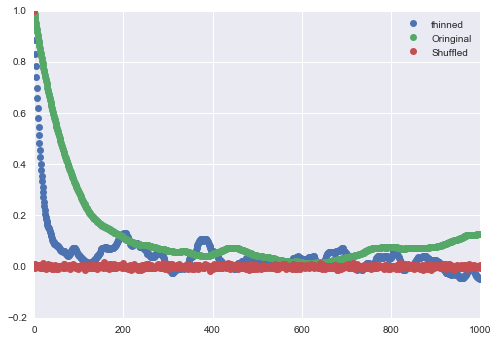

In [9]:
thinint=5
beta_cured=beta[0:len(alpha):thinint]

idp=np.random.permutation(beta)

xt=np.random.normal(size=1000)
#plt.hist(idp)

fig=plt.acorr(beta_cured-np.mean(beta_cured), normed=True, usevlines=False, maxlags=1000, label=u'thinned')
fig=plt.acorr(beta-np.mean(beta), normed=True, usevlines=False, maxlags=1000, label=u'Oringinal')
fig=plt.acorr(idp-np.mean(idp), normed=True, usevlines=False, maxlags=1000, label=u'Shuffled')

plt.xlim( (0,1000))
plt.legend()

    

### Series of histograms:
By plotting a histogram for every set of $k$ iterations (of the order of 100) beyond some burn in threshold $n$ and if the histograms are not visibly different this may be an evidence for convergence (or the opposite). Note that such diagnostics should be carried out for each parameter, because convergent behavior by one variable does not imply evidence for convergence for other parameter in the analysis. 

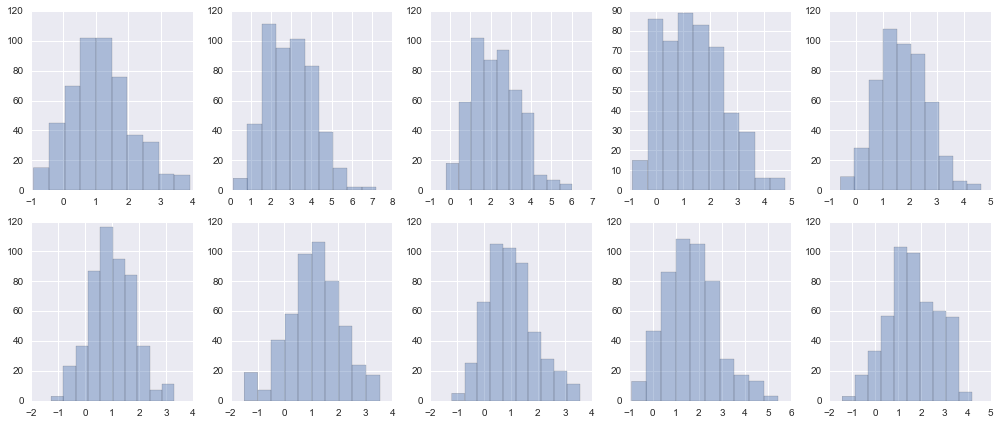

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(14,6))
axes = axes.ravel()
for i in range(10):
    axes[i].hist(alpha[500*i:500*(i+1)], alpha=0.4)
plt.tight_layout()

### Parallel chains:
We can run multiple parallel chains rather than a long chain. In this case, the final values of c chains run for n iterations are plotted in a histogram; just as above, this is repeated every $k$ iterations thereafter, and the histograms of the endpoints are plotted again and compared to the previous histogram. This is repeated until consecutive histograms are not different.

## Comparing chains:
We can detect lack of convergence by examining the traces of several MCMC chains initialized with different starting values. Plotting these traces together should show each chain tending toward the same equilibrium value, with approximately the same variance. Since MH is ergotic this should be sufficient. Again, however, this approach is only a heuristic method, and cannot always detect lack of convergence, even though chains may appear ergodic.



In [11]:
n_iter = 50000
trace2, acc2 = metropolis(n_iter, (1,7), 1)
trace, acc = metropolis(n_iter, (1,7), 1)

Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000
Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000


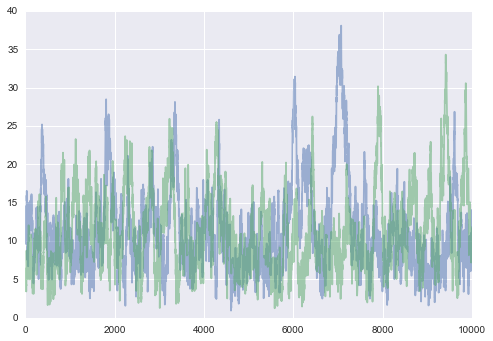

In [12]:
plt.plot( trace[burnin:burnin+10000,1], alpha=0.5)
plt.plot( trace2[burnin:burnin+10000,1], alpha=0.5)

# Formal Methods

In this section we discuss a few formal methods. But again we work with an example.  

### Example: Estimate maize plant weight given bark diameter and plant height.

This very simple dataset is a selection of maize bark diameter ($d$), height ($h$)  with the  weight for each plant ($w$). We wish to estimate a simple linear relationship between these variables, using the Metropolis-Hastings algorithm.
We model the weight as a function of diameter and height as

$$w_i=β_0+β_1 f(h_i, d_i) + \epsilon$$

$$\epsilon \sim N(0,\sigma_{\epsilon})$$

where $\beta_0$ and $\beta_1$ are the parameters to be estimated, and we are parametrizing the gaussian by its precision $\tau$, which is $1/\sigma_e^2$.

Obviously a good model for that is something that captures the volume: 

$$ f(h_i,d_i) = h_i d_i^2 $$ 

and we rename this quantity as $x_i$, so:

$$w_i=\beta_{0}+\beta_{1} x_i + \epsilon$$ 

and our goal is to estimate the posteriors of $\beta_0$, $\beta_1$ and $\sigma_{\epsilon}$. 

In [13]:
D=np.array([2.3,1.9,2.2,2,1.7,1.9,2.2,1.9,2.3,2.3,2.1,2.1,2.1,2.2,2,2.1,2.4,1.9,2.7])
H=np.array([176,177,266,264,203,230,220,230,230,245,240,255,210,250,220,240,165,155,185])
W = np.array([735,355,995,750,500,560,910,725,1040,985,895,910,715,1055,720,755,785,555,970])

Always start with exploring the data! Lets examine the relationship of $x$ and $w$.


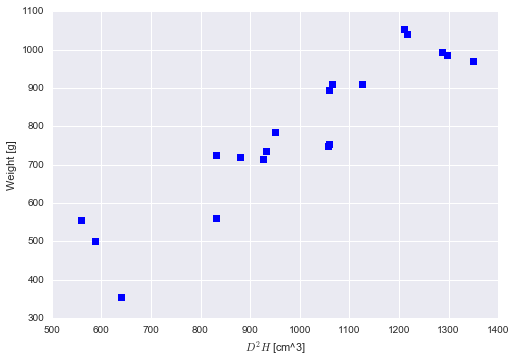

In [14]:
plt.plot(H*D**2, W, 'bs')
plt.xlabel('$D^2 H$ [cm^3]')
plt.ylabel('Weight [g]')

In [15]:
X = H*D**2

model = lambda  beta0,beta1,X : beta0+beta1*X

The likelihood for this model for each measurement as described in Lecture 5 is: 

$$ p(W_i| X_i,\theta) = N((\beta_0+\beta_1 X), \sigma_{\epsilon})$$

Once again, the parametrization is in terms of the precision $\tau=1/\sigma_{\epsilon}^2$. The conjugate priors for the $\beta$'s is a normal and for $\tau$ is the Gamma (inverse Gamma for the standard deviation). Thus, $\theta = (\beta_0, \beta_1, \tau)$.

This function calculates the joint log-posterior, which we then use inside a metropolis routine:

In [16]:
from scipy.stats import distributions
dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf
normal = distributions.norm.pdf

def calc_posterior(beta0, beta1, t, y=W, x=X):
    # Calculate joint posterior, given values for a, b and t

    # Priors on beta
    logp = dnorm(beta0, 0, 1000) + dnorm(beta1, 0, 1000)
    # Prior on t
    logp += dgamma(t, 0.001, 0.001)
    # Calculate mu
    mu = beta0 + beta1*x
    # Data likelihood
    logp += sum(dnorm(y, mu, t**-0.5))
    
    return logp

In [17]:
rnorm = np.random.normal
runif = np.random.rand


def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    #  proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print 'Iteration', i
    
        # Grab current parameter values
        current_params = trace[i]
        p = trace[i].copy() 
        for j in range(n_params):
                 
            # Get current value for parameter j

    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
            p[j] = trace[i+1,j]  
    return trace, accepted

In [18]:
n_iter = 20000
trace, acc = metropolis(n_iter, (22,0,1), 0.001)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000


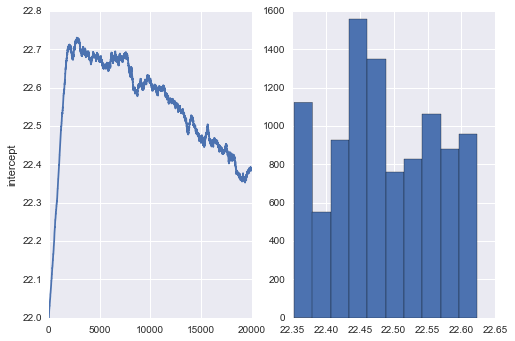

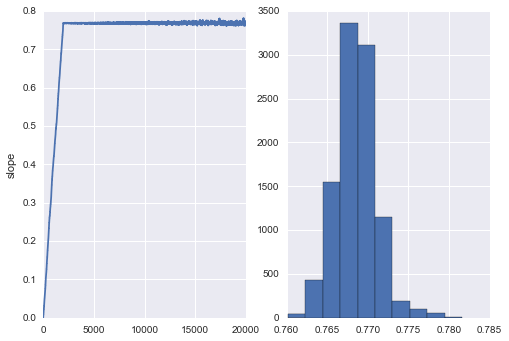

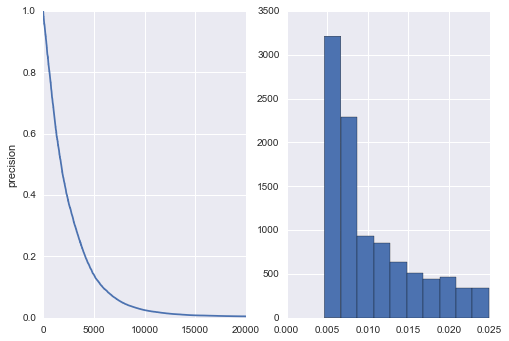

In [19]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace.T):
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[n_iter/2:])

In [20]:
b0=np.mean(trace.T[0,4000:])
b1=np.mean(trace.T[1,4000:])
sb0=np.std(trace.T[0,4000:])
sb1=np.std(trace.T[1,4000:])
tau =np.std(trace.T[2,4000:])
print b0, b1, sb0, sb1, tau, 1.0/np.sqrt(tau)

22.5481360618 0.768435291738 0.101603462753 0.00206566384771 0.0469839117399 4.61344570682


Using the posterior means we can now look at the resuls (see below for proper Bayes approach to this)

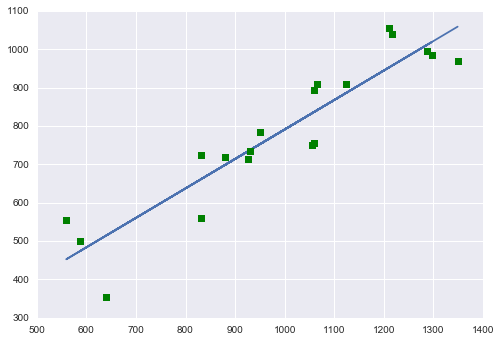

In [21]:
plt.plot(X, model(b0,b1,X))
plt.plot(X, W, 'gs')

## Geweke test:
Geweke test is a time-series approach that compares the mean and variance of segments from the beginning and end of a single chain.

$$z=\frac{\bar{\theta}_a-\bar{\theta}_b}{\sqrt{ \rm{var}(\theta_a)+\rm{var}(\theta_b)}}$$

where $a$ and $b$ here are the early and late segments. If $z$ is small then this is an evidence of convergence. 
Any value below 2 is considered convergence. This iseasily understood if we consider a white noise (i.e. no correlation normally distributed chain). 

Where we needed to define the beginning and the end of the chain. For the beginning we choose anything for it becomes obvious when the burnin is sufficient. For the end of the chain a rule is to start just half way from the chain. 

(20001L, 3L)


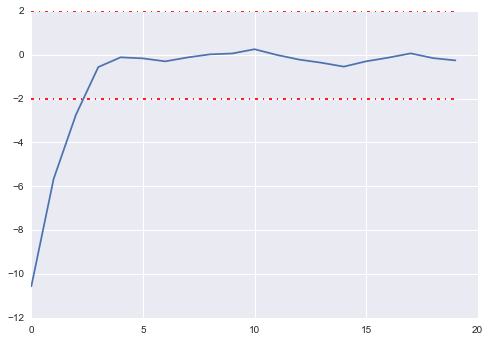

In [22]:
def Geweke(trace, intervals=20, length=200, first=None):
    
    if first is None:
        first=0.1*len(trace)
        
    # take two parts of the chain. 
    # subsample lenght 
    nsl=length
    
    z =np.empty(intervals)
    for k in np.arange(0, intervals):
        # beg of each sub samples
        bega=first+k*length
        begb = len(trace)/2 + k*length
        
        
        
        sub_trace_a = trace[bega:bega+nsl]
        sub_trace_b = trace[begb:begb+nsl]
        
        
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        var_a  = np.var(sub_trace_a)
        var_b  = np.var(sub_trace_b)
        
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z

print trace.shape
z = Geweke(trace[:,1], first=1000, length=300)

plt.plot( [2]*len(z), 'r-.')
plt.plot(z)
plt.plot( [-2]*len(z), 'r-.')

## Gelman-Rubin  test:

This convergence diagnostic was proposed by Gelman and Rubin (1992). This diagnostic uses multiple chains to check for lack of convergence, and is based on the notion that if multiple chains have converged, by definition they should appear very similar to one another; if not, one or more of the chains has failed to converge.

The Gelman-Rubin diagnostic uses an analysis of variance approach to assessing convergence. That is, it calculates both the between-chain variance (B) and within-chain variance (W), and assesses whether they are different enough to worry about convergence. Assuming $m$ chains, each of length $n$, quantities are calculated by:

$$ B = \frac{n}{m-1} \sum_{j=1}^{m} (\bar{\theta_j} - \bar{\theta})^2 $$

where $\bar{\theta_j}$ is the estimate of the $m$-th chain.

$$ W = \frac{1}{m} \sum_{j=1}^{m} \left[ \frac{1}{n-1} \sum_{i=1}^{n} (\theta_{ij} - \bar{\theta_j})^2 \right] $$

We can use those values to calculate the posterior variance of $\theta$ (marginal posterior to be precise) 

$$ \hat{\rm{var}}(\theta \vert y) = \frac{n-1}{n} W + \frac{1}{n} B $$


Assuming θ is initialized to random starting points in each chain, this quantity will overestimate the true marginal posterior variance. At the same time, W will tend to underestimate the within-chain variance early in the sampling run. However, in the limit as n→∞, both quantities will converge to the true variance of θ. In light of this, the Gelman-Rubin statistic monitors convergence using the ratio:

$$ \hat{R} = \sqrt{ \frac{\hat{\rm{var}}(\theta \vert y)}{W}} $$

This is called the __potential scale reduction__, since it is an estimate of the potential reduction in the scale of θ as the number of simulations tends to infinity. In practice, we look for values of $\hat{R}$ close to one (say, less than 1.1) to be confident that a particular estimand has converged. 

In [23]:
# Implementation of RB test [HOMEWORK  4]

## Predictive probability 

Checking for model convergence is only part of the story. In each of the examples above we assume a model. Do not confuse model and likelihood. In the maize example the model is the relationship of weight to height and diameter. 
We need to make sure that the estimated model adequately fits the data. 

An intuitive way of evaluating the model fit is to compare model predictions with the observations used to fit the model. In other words, the fitted model can be used to simulate data, and the distribution of the simulated data should resemble the distribution of the actual data.

And this is what Bayesian framework is good about. We can simulate data from the model in a natural way. 

To make predictions for a test case we average over all possible parameter  values, weighted by their posterior probability. This is in contrast to non Bayesian schemes, where a single parameter is typically chosen by some criterion. Thus the predictive distribution of  at some $x^{∗}$ is given by averaging the output of all possible linear models w.r.t. the posterior

\begin{eqnarray} 
p(w^{*} | x^{*},  x,w) &=& \int p( w^{*}|  x^{*}, {\bf \theta} ) p(\theta| x, w)d \theta
\end{eqnarray}

where $w^*$ represents some  new data that we predict its distribution, $\theta$ are the parameters $\beta_0$ and $\beta_1$, $x$ and $w$ are our measured values. 

Lets say we want to calculate the posterior predictive distribution at $x^* = 750$ where there seems to be a gap in the data. We can use the mode of the distribution to get an estimate of the weight there, and the spread of the distribution to get the uncertainty. To do this we marginalize the parameters in the above integral by summing the likelihood at 750 over all the samples from the posterior

In [24]:
asamples, bsamples, tsamples = trace[:,0], trace[:,1], trace[:,2]
asamples=asamples[4000:]
bsamples = bsamples[4000:]
tsamples = tsamples[4000:]
def mu_at_x(x):
    musamples = asamples + x*bsamples
    return musamples

In [25]:
np.mean(mu_at_x(750))

598.87460486567113

The functional form for the sampling distribution at a weight $w^*$ is given by the usual gaussian:

$$p( w^{*}_i|  x^{*}_i, \theta=(\beta_0, \beta_1, \tau)) = \frac{\tau}{2} \exp(-\frac{\tau}{2} (w_i - (\beta_0+\beta_1 x_i)^2)$$

And the total likelihood is the product of that. 

In [26]:
def post_pred(xstar):
    musamples = mu_at_x(xstar)
    pp = lambda wstar: np.sum(normal([wstar]*musamples.shape[0], musamples, tsamples**(-0.5)))
    return pp

In [27]:
pp750 = post_pred(750)
#vectorize so we can plot
ppvec750=np.vectorize(pp750)

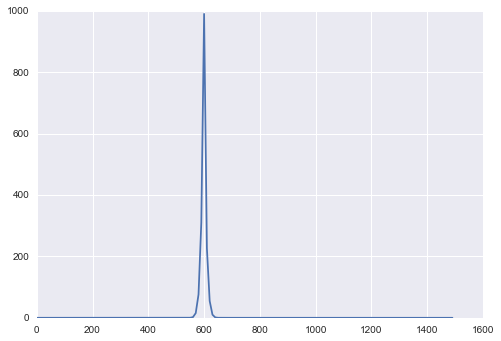

In [28]:
wrange=np.arange(0, 1500, 10)
plt.plot(wrange, ppvec750(wrange))

In [29]:
wrange[np.argmax(ppvec750(wrange))]

a750 = ppvec750(wrange)
print np.percentile(a750,50)
print wrange.shape

4.4697162613e-139
(150L,)


In [30]:
cdf = np.cumsum(a750)/np.sum(a750)
# get the left and right boundary of the interval that contains 95% of the probability mass 
right=np.argmax(cdf>0.975)
left=np.argmax(cdf>0.025)
print left, right

58 62


In [31]:
def lr_credible(s):
    cdf = np.cumsum(s)/np.sum(s)
    # get the left and right boundary of the interval that contains 95% of the probability mass 
    right=np.argmax(cdf>0.975)
    left=np.argmax(cdf>0.025)
    return left, right

In [32]:
predwmax=np.zeros(X.shape[0])
predwl=np.zeros(X.shape[0])
predwr=np.zeros(X.shape[0])
counter=0
for x in X:
    ppfunc = post_pred(x)
    ppfuncvec = np.vectorize(ppfunc)
    watx = ppfuncvec(wrange)
    predwmax[counter]=wrange[np.argmax(watx)]
    l,r = lr_credible(watx)
    predwl[counter]=wrange[l]
    predwr[counter]=wrange[r]
    counter=counter+1
                     

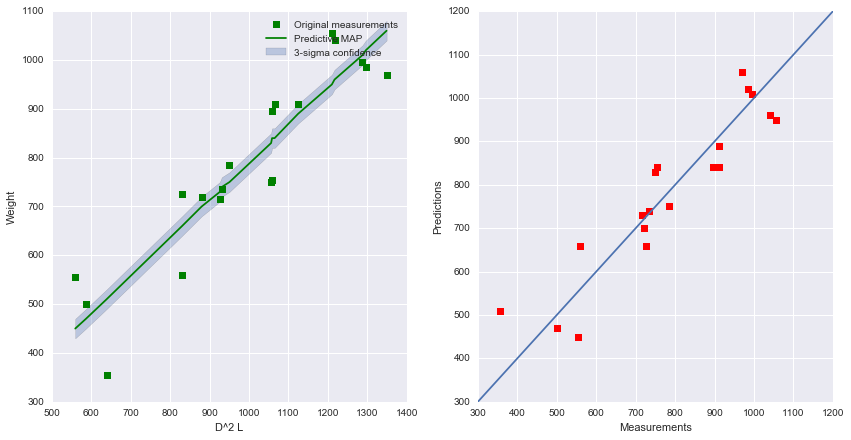

In [33]:
plt.figure(figsize=[14,7])
le=predwmax - predwl
ue=predwr - predwmax


idx = np.argsort(X)
plt.subplot(1,2,1)

plt.plot(X, W, 'gs', label='Original measurements')


plt.plot(X[idx], predwmax[idx], 'g', label='Predictive MAP')
#plt.errorbar(X, predwmax, yerr=[le, ue], fmt='-')
#plt.plot([300,1200],[300,1200])
plt.fill_between(X[idx], predwl[idx], predwr[idx], alpha=0.3, label='3-sigma confidence')
plt.xlabel('D^2 L')
plt.ylabel('Weight')
plt.legend()

plt.subplot(1,2,2)
plt.plot(W, predwmax, 'rs')
plt.plot([300,1200],[300,1200])  # THIS IS A 45 DEGREE LINE 
plt.xlabel('Measurements')
plt.ylabel('Predictions')

Materials for this lecture are borrowed from <a href="http://nbviewer.ipython.org/urls/raw2.github.com/fonnesbeck/Bios366/master/notebooks/Section4_5-Model-Checking.ipynb?create=1"> here </a>